# ml lab10

In [52]:
import numpy as np
import matplotlib.pyplot as plt

import sklearn
import sklearn.datasets
import sklearn.model_selection
import sklearn.metrics
import sklearn.tree
import sklearn.linear_model

### 1. get dataset from `sklearn`

In [7]:
boston = sklearn.datasets.load_boston()
boston.data.shape

(506, 13)

### 2. get train and validation sets

In [12]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    boston.data.astype(np.float32), 
    boston.target, 
    test_size=0.25, 
    random_state=42
)

X_train.shape, X_test.shape

((379, 13), (127, 13))

### 3-6. train with `DecisionTreeRegressor`

In [34]:
def default_get_weight(x):
    return 0.9

def iter_get_weight(i):
    return 0.9 / (1.0 + i)

def get_clf(depth):
    return sklearn.tree.DecisionTreeRegressor(max_depth=depth, random_state=42)

def predict_boosted(models, X, y, weights):
    p = np.zeros(y.shape)
    for i, model in enumerate(models):
        p += model.predict(X) * weights[i]

    loss = sklearn.metrics.mean_squared_error(y, p)
    return p, loss

def train_boosted(X, y, num_iters=50, get_weight=default_get_weight, depth=5):
    models = []
    
    y = np.copy(y)
    weights = np.ones(shape=(num_iters,))
    
    for i in range(num_iters):
        clf = get_clf(depth)
        clf.fit(X_train, y)
        
        models.append(clf)
        weights[i] = get_weight(i)
        
        pred, loss = predict_boosted(models, X_train, y_train, weights)
        
        h = clf.predict(X_train)
        y = y - h * weights[i]

    return models, weights

In [68]:
models, weights = train_boosted(X_train, y_train)

In [69]:
def print_results(models, weights):
    p, loss = predict_boosted(models, X_train, y_train, weights)
    test_p, test_loss = predict_boosted(models, X_test, y_test, weights)

    print(f'Training Set MSE loss:\t{loss}')
    print(f'Test Set MSE loss:\t{test_loss}')
    
    return test_loss
    
test_loss = print_results(models, weights)

Training Set MSE loss:	3.7686156404275976e-05
Test Set MSE loss:	13.600735758368467


### 7. change weights on each iteration

In [70]:
models, weights = train_boosted(X_train, y_train, get_weight=iter_get_weight)
test_loss = print_results(models, weights)

Training Set MSE loss:	1.4211440991285953
Test Set MSE loss:	8.987354822947314


> при константном весе модель имеет меньшую ошибку на тренировочных данных, но большую на валидационной выборке

### 8a. test on large number of iterations 

In [39]:
def test_num_iters(X_train, y_train, X_val, y_val):
    steps = 10
    iters = np.linspace(10, 400, steps, dtype=int)
    
    train_loss = np.zeros(steps)
    val_loss = np.zeros(steps)
    for i, num_iters in enumerate(iters):
        models, weights = train_boosted(X_train, y_train, num_iters, get_weight=iter_get_weight)
        
        p, loss = predict_boosted(models, X_train, y_train, weights)
        test_p, test_loss = predict_boosted(models, X_val, y_val, weights)
        
        train_loss[i] = loss
        val_loss[i] = test_loss

    best_iters = iters[val_loss.argmin()]
    return best_iters, train_loss, val_loss, iters

In [40]:
best_num_iters, train_loss, test_loss, iters = test_num_iters(X_train, y_train, X_test, y_test)
best_num_iters

400

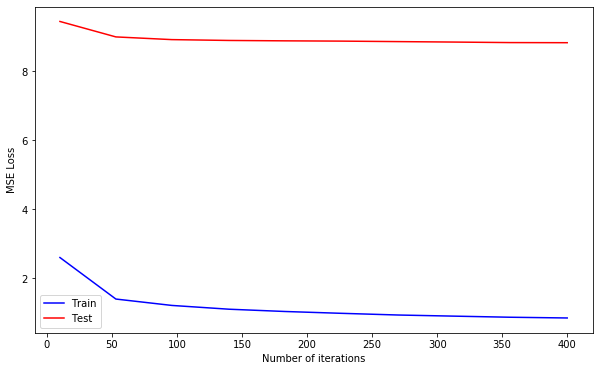

In [41]:
def plot_data(iters, train_loss, test_loss, xlabel):
    plt.figure(figsize=(10, 6))
    plt.plot(iters, train_loss, c='b', label='Train')
    plt.plot(iters, test_loss, c='r', label='Test')
    plt.xlabel(xlabel)
    plt.ylabel('MSE Loss')
    plt.legend()
    plt.show()
    
plot_data(iters, train_loss, test_loss, 'Number of iterations')

> По графику ошибка убывает с числом итераций для обоих выборок (тренировочной и валидационной) - те модель не переобучается с ростом числа итераций

### 8b. test on large tree depth

In [53]:
def test_tree_depth(X_train, y_train, X_val, y_val):
    depths = range(2, 20)
    steps = len(depths)
    
    train_loss = np.zeros(steps)
    val_loss = np.zeros(steps)
    for i, depth in enumerate(depths):
        models, weights = train_boosted(X_train, y_train, depth=depth, get_weight=iter_get_weight)
        
        p, loss = predict_boosted(models, X_train, y_train, weights)
        test_p, test_loss = predict_boosted(models, X_val, y_val, weights)
        
        train_loss[i] = loss
        val_loss[i] = test_loss

    best_depth = depths[val_loss.argmin()]
    return best_depth, train_loss, val_loss, depths

In [54]:
best_depth, train_loss, test_loss, depths = test_tree_depth(X_train, y_train, X_test, y_test)
best_depth

5

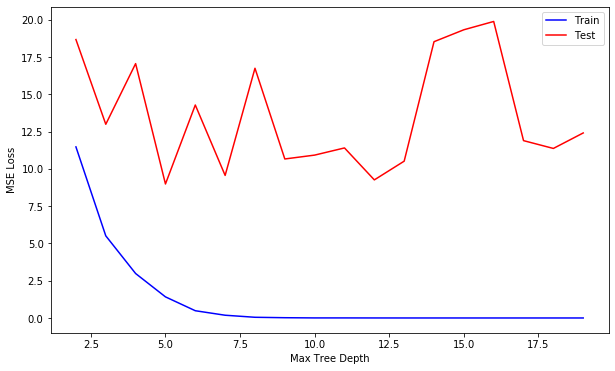

In [55]:
plot_data(depths, train_loss, test_loss, 'Max Tree Depth')

> При увеличении глубины дерева, ошибка на тренировочной выборке падает, а на валидационной скачет - что говорит о переобучении модели

### 9. compare with `sklearn.linear_model`

In [72]:
lr = sklearn.linear_model.LinearRegression()
lr.fit(X_train, y_train)

lr_p = lr.predict(X_train)
lr_test_p = lr.predict(X_test)
lr_train_loss = sklearn.metrics.mean_squared_error(y_train, lr_p)
lr_test_loss = sklearn.metrics.mean_squared_error(y_test, lr_test_p)

In [74]:
print(f'LR train MSE:\t{lr_train_loss}')
print(f'LR test MSE:\t{lr_test_loss}')

print(f'GB RMSE loss:\t{np.sqrt(test_loss)}')
print(f'LR RMSE loss:\t{np.sqrt(lr_test_loss)}')
print(f'GB perfomance is {np.sqrt(lr_test_loss)/np.sqrt(test_loss):.2}x better')

LR train MSE:	22.3400585447522
LR test MSE:	22.09877006714036
GB RMSE loss:	2.9978917296906027
LR RMSE loss:	4.7009328932819665
GB perfomance is 1.6x better


### 10. conclusions

Был рассмотрен метод градиентного бустинга используя деревья решений.

Проанализировано влияние параметров (количество итераций и глубина дерева) на качество обучения.

Проведено сравнение градиентного бустинга с линейной регрессией.